In [60]:
from Crypto.Cipher import AES
import hashlib
import random
from tqdm.notebook import tqdm
from Crypto.Util.number import long_to_bytes, bytes_to_long
from Crypto.Util.Padding import pad, unpad
import os

def xor_bytestring(a, b):        
    return bytes([i^j for i, j in zip(a, b)])
def xor_hexstring(a, b):
    res = b''
    x = bytes.fromhex(a)
    y = bytes.fromhex(b)
    for i, j in zip(x, y):
        res+= bytes([i ^j])
    return res

def xor_bytestring_rep(a, b):
    res = b''
    print(len(a), len(b))
    if len(a) > len(b):
        for i in range(0, len(a), len(b)):
            res += xor_bytestring(a[i:i+len(b)], b)
    else:
        for i in range(0, len(b), len(a)):
            res += xor_bytestring(b[i:i+len(a)], a)
    return res

# Prerequisites

- Block Ciphers pdf
- Stream ciphers pdfs
- No need to understand the inner workings of the block ciphers. We'll just understand them as black boxes

# Theory - Modes of operation

Video resources
- https://www.youtube.com/watch?v=Rk0NIQfEXBA - Computerphile
- https://www.youtube.com/watch?v=6rE-KlhBlq4 - Professor Messer
- 

Let $(E, D)$ be a block cipher. Now block ciphers encrypt blocks of text so we need a way to chain them to encrypt a bigger file
- Ex: AES128 enccrypts 128 bits of text so we need to chain them to encrypt / decrypt data
- Basically we are looking for ways to use block ciphers for encryption

Let 
- $E, D: \mathcal{K} \times \{0, 1\}^l \longrightarrow \{0, 1\}^l$ where $l$ is the number of bits
- $m, c \in \{0, 1\}^l$

For now we know 
- $c = E(k, m)$
- $m = D(k, m)$

We want to learn to do 
- Encryption: $(c_1, c_2, ... c_n) \longleftarrow MAGIC \longleftarrow (m_1, m_2, ... m_n)$
- Decryption:  $(m_1, m_2, ... m_n)\longleftarrow MAGIC \longleftarrow (c_1, c_2, ... c_n)$



> **Def - Deterministic encryption scheme**  
> An encryption is *deterministic* if a particular plaintext is mapped to a fixed ciphertext if the key is unchanged

> **Def - Deterministic probabilistic scheme**  
> An encryption is *probabilistic* if it uses randomness to achieve a non-deterministic generation of the ciphertext

What are we analyzing at a mode of operation?
- How does it work?
- Security issues
- Implementation details (If encrypt/decrypt is paralellizable or not)

**One more note**
- In the coding part the messages need to be padded to fit the block size
- Padding attacks are a security issue for padding oracles

## ECB mode (Electronic Code Book Mode) 

### Theory

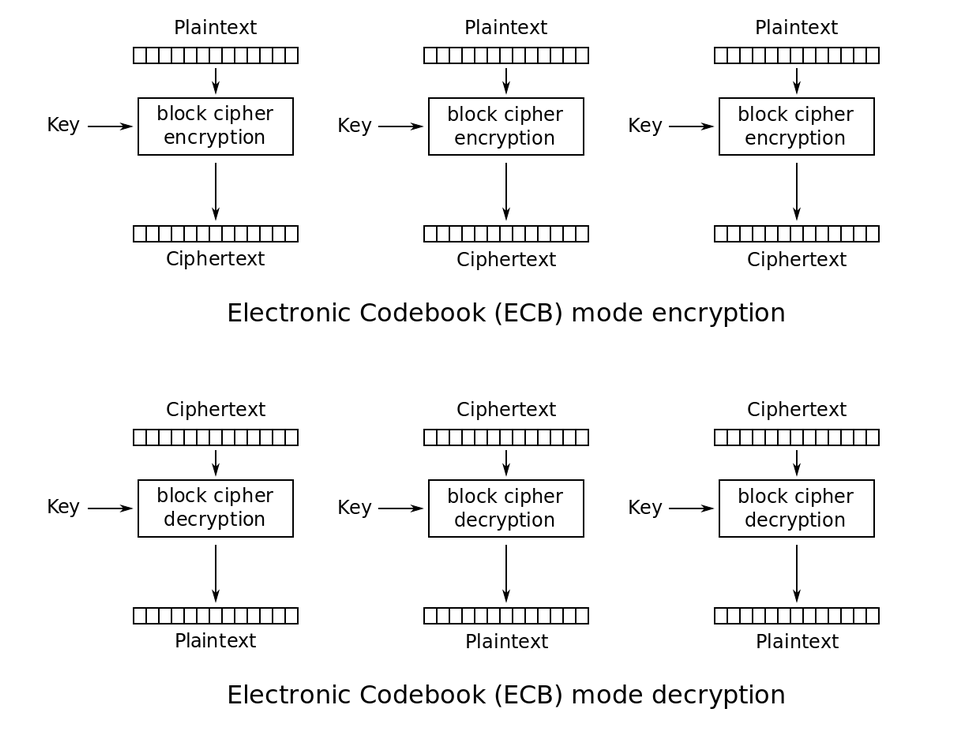

**How does it work?**
- Encryption 
    - $c_i = E(k, m_i) $
- Decryption
    - $m_i = D(k, c_i) $

**Parallelizable?**
- Encryption - YES
- Decryption - YES

**Security**
- Strengths
    - A single ECB block is secure
- Weaknesses
    - if $m_i = m_j => c_i = c_j$ 
        - Distinguishable from random
        - The same input generates the same output
    - Deterministic. The message encryption is the same every time
    - Weak to man in the middle by changing blocks
    - Data patterns can be found when encrypting large blocks of data
        - Ex: in images
    


### Code

In [21]:
KEY = b'some secret key1'

In [22]:
m = b'a message secret longer than 128 bits'
print(len(m) * 8, len(m) * 8 > 128)

296 True


In [23]:
pad(m, 16)

b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'

In [24]:
cipher = AES.new(KEY, AES.MODE_ECB)

c = cipher.encrypt(pad(m, 16)) # we pad the message
print(c)

m_decr = cipher.decrypt(c)
print(m_decr)

b'Ub,I\xc36\x07W\x1as\x03\x1d\x14\x99m_\x13\xd44\x1f\xd8\xa3\xb1\x9c\x87l&U\x93\x00\xac\xf7Y\x10wD.\xa2\xb9\x17L\x1a\xe3N\x1c\xf9\x8b_'
b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'


In [28]:
# Weakness 1
m = b'a' * 16 + b'b' * 16 + b'a' * 16

cipher = AES.new(KEY, AES.MODE_ECB)

c = cipher.encrypt(m) # we pad the message
print(c)
print("First 16 bytes == last 16 bytes? ", c[:16] == c[-16:])

m_decr = cipher.decrypt(c)
print(m_decr)

b"\xe6\x80\x05\x05\xc0~Pd/~\x1b\x0e\x04.\x07\xce\\K/'\x13\x0b6G\x16\xce%\xb8#\xf1\xa4b\xe6\x80\x05\x05\xc0~Pd/~\x1b\x0e\x04.\x07\xce"
First 16 bytes == last 16 bytes?  True
b'aaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbaaaaaaaaaaaaaaaa'


## CBC Mode (Cipher block chaining)

### Theory

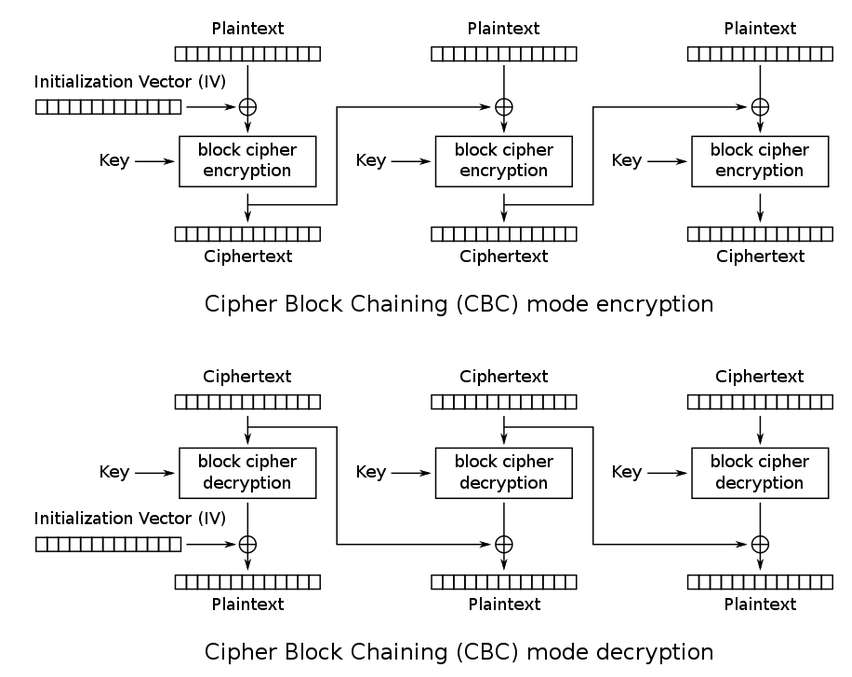

Solves ECB problems: 
- Makes encryption probabilistic (Uses an $IV$ = initialization vector)
- Combine encryption of all blocks

**How does it work?**
- Encryption 
    - $c_1 = E(k, m_1 \oplus IV)$
        - $IV$ = initialization vector
    - $c_i = E(k, m_i \oplus c_{i-1}) \text{ for } i > 1$
- Decryption
    - $m_1 = D(k, c_1) \oplus IV$
    - $m_i = D(k, c_i) \oplus c_{i-1}$

**Parallelizable?**
- Encryption - NO
- Decryption - YES

**Security**
- $IV$ security (Security depends on how the $IV$ is manipulated
    - If $IV$ is the same then we have deterministic encryption 
    - If $IV$ is used as a random nonce and it's sent with the ciphertext
        - Is not indistinguishable under a CPA
    - If $IV$ is completely random as an internal state
        - Secure under CPA

In [35]:
KEY = b'some secret key1'
IV = os.urandom(16)
IV

b'\x88\x99\x1b/\xb6m\xca\xa0\x9b\x8c\x9fX\xe6b\xd5T'

In [30]:
m = b'a message secret longer than 128 bits'
print(len(m) * 8, len(m) * 8 > 128)

296 True


In [31]:
pad(m, 16)

b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'

In [37]:
cipher = AES.new(KEY, AES.MODE_CBC, iv = IV)

c = cipher.encrypt(pad(m, 16)) # we pad the message
print(c)

cipher = AES.new(KEY, AES.MODE_CBC, iv = IV)
m_decr = cipher.decrypt(c)
print(m_decr)

b"G\x94-\xbb\xac1\x06'e|N\xa3c\xa3\xad\xb4\xd1$\x7f\xea)'y\xf2\xfb\xa2\xa9\xab9(n\xc5\x8a\x01!\xf3\x92\xd9\x05\xaf\x00\xa3\xbb\xf2\x8b\xda5\xcf"
b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'


In [39]:
# ECB weakness isn't here anymore
m = b'a' * 16 + b'b' * 16 + b'a' * 16

cipher = AES.new(KEY, AES.MODE_CBC, iv = IV)

c = cipher.encrypt(m) # we pad the message
print(c)
print("First 16 bytes == last 16 bytes? ", c[:16] == c[-16:])

cipher = AES.new(KEY, AES.MODE_CBC, iv = IV)
m_decr = cipher.decrypt(c)
print(m_decr)

b'/{\x1b\x03t>:\xed\xa7\x061\xbb\x02\\\xba\xd5\x06\xa3\x1d$u+\xc5S)f\x95\xcc\x11\xf75\xae\xa3\xfc*\x11r3X~1m\x1d\x01\x1a\xdc\x8b\x95'
First 16 bytes == last 16 bytes?  False
b'aaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbaaaaaaaaaaaaaaaa'


## CFB (Cipher FeedBack)

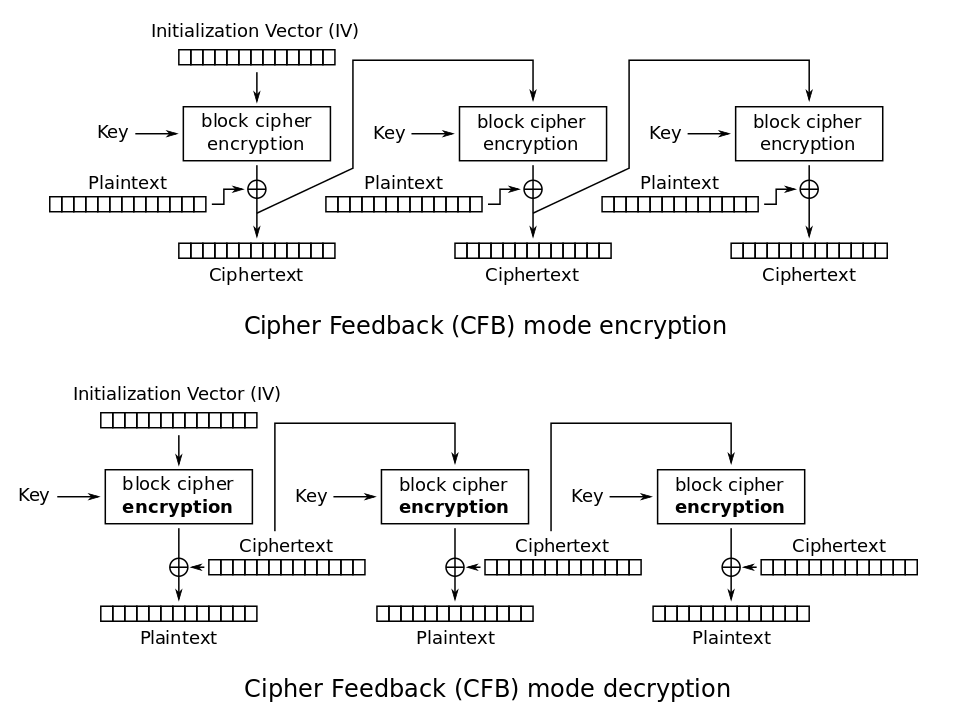

- uses the block cipher to produce a stream cipher

**How does it work?**
- Encryption 
    - $c_0 = IV$
    - $c_i = E(k, c_{i-1}) \oplus m_i \text{ for } i>=1$
    - The output is $IV || c_1 || c_2 ||...$
- Decryption
    - $m_i = E(k, c_{i-1}) \oplus c_i$
    

**Parallelizable?**
- Encryption - NO
- Decryption - YES

**Security**
- When $IV$ is used as a nonce then it is not indistinguishable from random under CPA
    - Attacker has $IV || c_1 || c_2 ||...$
    - Attacker queries $IV = c_1$ and $m_1 = 0$ => we will get $c' = E(k, c_1) \oplus 0$ 
    - We can decrypt $m_2 = E(k, c_{1}) \oplus c_2 = c' \oplus c_2$
    - We can get the messages after the first


In [9]:
m = b'a message secret longer than 128 bits'
print(len(m) * 8, len(m) * 8 > 128)

cipher = AES.new(KEY, AES.MODE_CFB, iv = IV)
c = cipher.encrypt(pad(m, 16)) # we pad the message
print(c)

296 True
b'\x9c\xb5\rP\xe6\xbd\xef\x97BY\x8b\x14mMP\xb7\xa0f\x1cDxe\x05}8\x0b\xd2\xa5\xca\xbbgky\xf6s4|\x13.e\x97?\x02\x1d\x0eu \x16'


In [11]:
cipher = AES.new(KEY, AES.MODE_CFB, iv = IV)
m_decr = cipher.decrypt(c)
print(m_decr)

b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'


#### The attack

In [99]:
KEY = b'some secret key1'
IV = os.urandom(16)
IV

b'\x95\xd4\xfd&\x81-Y\xb1\xc5\xaa\x17>B\x9d\x02N'

In [109]:
m = b'some trash inputSUPER SECRET STUFF HERE'
print(len(m))

cipher = AES.new(KEY, AES.MODE_CFB, iv = IV, segment_size = 128)
c = cipher.encrypt(pad(m, 16)) # we pad the message
print(len(c), c)

39
48 b'L\xe7\x06\x91\xff\xcaC\x98\x85\xe51\xf1$\x02\x8c9\x04\xfd\xd1$+|UkzqP7y\x05P\x0eCsA~s\xf5[\xcbP\xdbS\xd7\x81\x0e~\xe3'


In [110]:
cipher2 = AES.new(KEY, AES.MODE_CFB, iv = c[:16], segment_size = 128) #encryption oracle
c_ = cipher2.encrypt(bytes([0]) * 16)
c_

b'W\xa8\x81ay\\\x06.9#\x15cYV\x04['

In [111]:
xor_bytestring(c_, c[16:32]) 

b'SUPER SECRET STU'

In [112]:
cipher2 = AES.new(KEY, AES.MODE_CFB, iv = c[16:32], segment_size = 128) #encryption oracle
c_ = cipher2.encrypt(bytes([0]) * 16)
c_
xor_bytestring(c_, c[32:48]) 

b'FF HERE\t\t\t\t\t\t\t\t\t'

## OFB mode (output feedback mode)

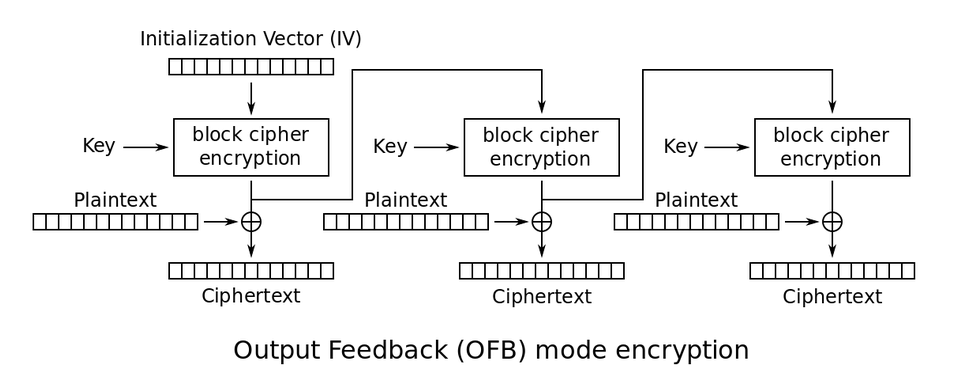

- Transforms a block cipher into a stream cipher -> We use the block cipher to create the keystream $y$
- It's symmetric => Encryption is the same as decryption

**How does it work?**
- Encryption 
    - $y_0 = IV$
    - $y_i = E(k, y_{i-1})$
    - $c_i = m_i \oplus y_i$
    - The output is $IV || c_1 || c_2 ||...$
- Decryption
    - Same as encryption, just reverse $m_i$ with $c_i$
    

**Parallelizable?**
- Encryption - NO
- Decryption - NO
- Note:
    - The key $y$ can be generated in advance

**Security**
- flipping a bit in the ciphertext changes the plaintext at the same location
- When used with a fixed $IV$ OFB is not indistinguishable from random under a CPA

In [3]:
KEY = b'some secret key1'
IV = os.urandom(16)

In [4]:
m = b'a message secret longer than 128 bits'
print(len(m) * 8, len(m) * 8 > 128)

296 True


In [6]:
cipher = AES.new(KEY, AES.MODE_OFB, iv = IV)

c = cipher.encrypt(pad(m, 16)) # we pad the message
print(c)

cipher = AES.new(KEY, AES.MODE_OFB, iv = IV)
m_decr = cipher.decrypt(c)
print(m_decr)

b"\x1bJ\xa4C\xf5\xd0\x90$\x8c\x16\xd1DU\x9d.\x00\x86/\x18\x02\x8f\x81s\x18\x1d\x11\x95\xd1'f\x1aM\xbd\xdd\x99p.P\x8d\xf6\xae}Wm\xc4\xd1\x05\xfe"
b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'


## CTR (Counter mode)

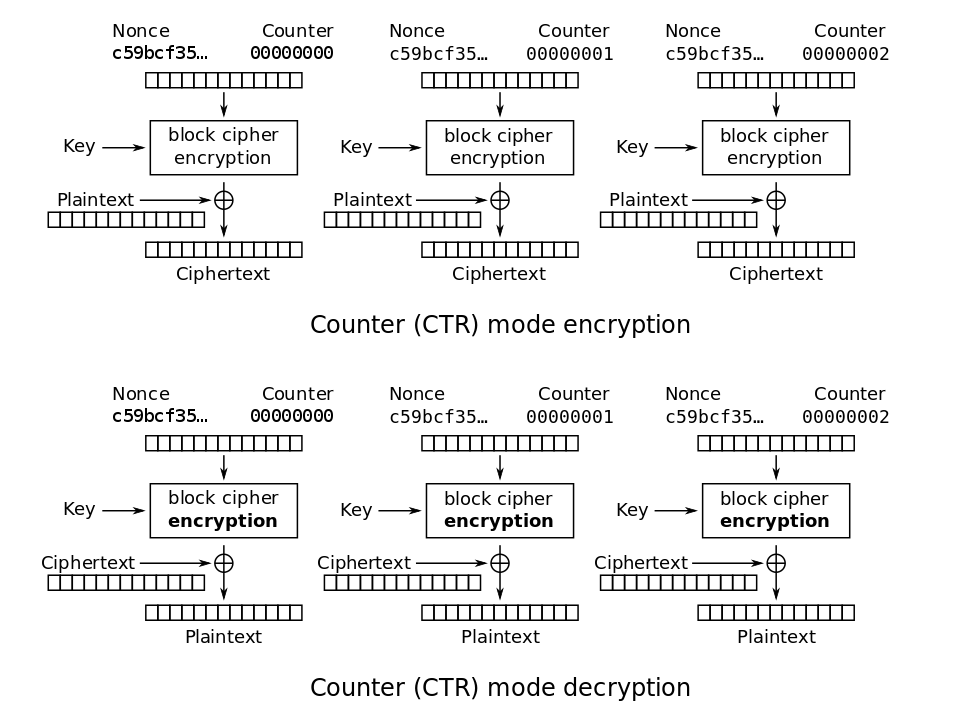

- Transforms the block cipher into a stream cipher
- Uses the block cipher on a counter to generate a keystream

**How does it work?**
- Encryption 
    - $c_i = m_i \oplus E(k, IV + i)$
- Decryption
    - $m_i = c_i \oplus E(k, IV + i)$
    
**Parallelizable?**
- Encryption - YES
- Decryption - YES
- Note:
    - The key $y$ can be generated in advance

**Security**
- Is indistinguishable from random  under CPA

In [90]:
from Crypto.Util import Counter
KEY = b'some secret key1'
IV = os.urandom(16)

In [ ]:
m = b'a message secret longer than 128 bits'
print(len(m) * 8, len(m) * 8 > 128)

In [93]:
cipher = AES.new(KEY, AES.MODE_CTR,  counter = Counter.new(128, initial_value=bytes_to_long(IV)))
c = cipher.encrypt(pad(m, 16)) # we pad the message
print(c)

cipher = AES.new(KEY, AES.MODE_CTR, counter = Counter.new(128, initial_value=bytes_to_long(IV)))
m_decr = cipher.decrypt(c)
print(m_decr)

b'(\x00!\xd9\xe9\xb9\xf6e\x86\xaeQ\xa9\xfb?\xb0\x0b\xb7\x17\x86\xb2v8\xa5\x08Pt\x95\xb0\xa2\xc7K5\xe9\xad<\xbe\x84*Ds\\\x9b\xd5\x880=\xa0\x7f'
b'a message secret longer than 128 bits\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b\x0b'


 # Resources

- https://www.youtube.com/watch?v=Rk0NIQfEXBA
- https://www.geeksforgeeks.org/block-cipher-modes-of-operation/
- http://www.crypto-it.net/eng/theory/modes-of-block-ciphers.html
- https://www.highgo.ca/2019/08/08/the-difference-in-five-modes-in-the-aes-encryption-algorithm/